# **Import Kaggle Dataset**

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!rm -r ~/.kaggle
! mkdir ~/.kaggle
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
! kaggle datasets download thedownhill/art-images-drawings-painting-sculpture-engraving

 99% 577M/583M [00:07<00:00, 103MB/s] 
100% 583M/583M [00:07<00:00, 85.3MB/s]


In [5]:
import zipfile
with zipfile.ZipFile("/content/art-images-drawings-painting-sculpture-engraving.zip","r") as zip_ref:
  zip_ref.extractall("/content")


In [6]:
!cp -r /content/musemart/dataset_updated/training_set /content/dataset/dataset_updated
!cp -r /content/musemart/dataset_updated/validation_set /content/dataset/dataset_updated
!rm -r /content/musemart

In [7]:
!cp -r /content/dataset/dataset_updated/training_set/drawings /content/dataset/dataset_updated
!cp -r /content/dataset/dataset_updated/training_set/engraving /content/dataset/dataset_updated
!cp -r /content/dataset/dataset_updated/training_set/iconography /content/dataset/dataset_updated
!cp -r /content/dataset/dataset_updated/training_set/painting /content/dataset/dataset_updated
!cp -r /content/dataset/dataset_updated/training_set/sculpture /content/dataset/dataset_updated

In [8]:
!cp -r /content/dataset/dataset_updated/validation_set/drawings /content/dataset/dataset_updated
!cp -r /content/dataset/dataset_updated/validation_set/engraving /content/dataset/dataset_updated
!cp -r /content/dataset/dataset_updated/validation_set/iconography /content/dataset/dataset_updated
!cp -r /content/dataset/dataset_updated/validation_set/painting /content/dataset/dataset_updated
!cp -r /content/dataset/dataset_updated/validation_set/sculpture /content/dataset/dataset_updated

In [9]:
!rm -r /content/dataset/dataset_updated/training_set
!rm -r /content/dataset/dataset_updated/validation_set

# **Data Cleaning**

In [10]:
import os

In [11]:
IMAGES_PATH = "/content/dataset/dataset_updated"

In [12]:
def get_files_number(path=IMAGES_PATH):
  total = 0
  for root,dirs,files in os.walk(path):
    total+=len(files)
  return total

In [ ]:
#rimuoviamo le immagini corrotte
from pathlib import Path
import imghdr

data_dir = IMAGES_PATH
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [14]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
STEPS_PER_EPOCH = 8
BATCH_SIZE = 32

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_set = tf.keras.utils.image_dataset_from_directory(
    IMAGES_PATH,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size = (IMG_WIDTH,IMG_HEIGHT),
    batch_size = 32
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    IMAGES_PATH,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (IMG_WIDTH,IMG_HEIGHT),
    batch_size = 32
)


Found 8741 files belonging to 5 classes.
Using 6993 files for training.
Found 8741 files belonging to 5 classes.
Using 1748 files for validation.


In [16]:
num_classes = train_set.class_names

In [17]:
type(train_set)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [18]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):

    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate() #supponendo validation_data_fraction = 0.3 
    train_dataset = dataset.filter(lambda f, data: f % 100 > validation_data_percent) #ogni 100 elementi, prende gli ultimi 70
    validation_dataset = dataset.filter(lambda f, data: f % 100 <= validation_data_percent) #ogni 100 elementi, prende i primi 30

    # rimuoviamo enumerazione
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

In [19]:
train_set,test_set = split_dataset(train_set,0.2)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

# **Training and Testing**

In [30]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255,input_shape = [IMG_HEIGHT,IMG_WIDTH,3]),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(len(num_classes))
])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                    

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

In [23]:
def learning_rate_exponential(epoch):
  return 0.1*0.1**(epoch/20)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.25,patience=5)

In [24]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=20,verbose=1)

In [ ]:
history = model.fit(train_set,epochs=35,validation_data=(validation_set),callbacks=[lr_scheduler])

In [29]:
prediction = model.evaluate(test_set)

61/61 [==============================] - 5s 76ms/step - loss: 0.5843 - accuracy: 0.8575


In [21]:
import numpy as np

y_pred = []
y_true = []

for image_batch, label_batch in test_set:
   y_true.append(label_batch)
   preds = model.predict(image_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [34]:
confusion_matrix = tf.math.confusion_matrix(correct_labels,predicted_labels)

In [35]:
confusion_matrix

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[180,  43,  15,  14,  38],
       [ 41, 143,   6,   2,  11],
       [  8,   2, 480,   5,  10],
       [  7,   0,  18, 464,  17],
       [ 17,   3,  10,   9, 394]], dtype=int32)>

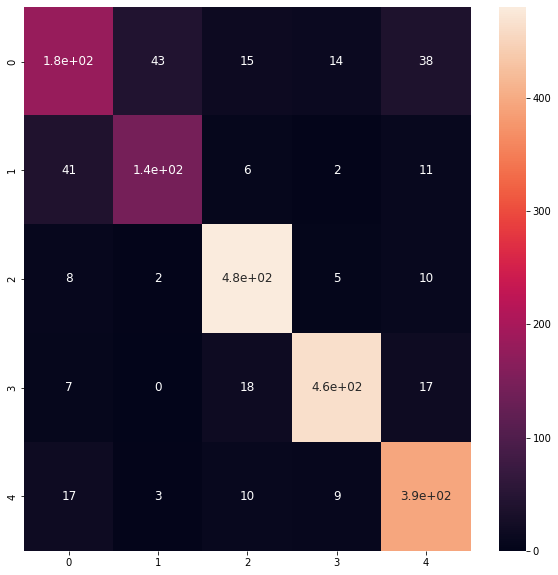

In [39]:
import seaborn as sns 
import pandas as pd 
from matplotlib import pyplot as plt

cm = pd.DataFrame(confusion_matrix.numpy(), # use .numpy(), because now confusion is tensor
               range(5),range(5))

plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, annot_kws={"size": 12})
plt.show()